In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from kerod.core.standard_fields import BoxField, DatasetField
from kerod.dataset.preprocessing import preprocess_coco_example, expand_dims_for_single_batch
import functools

ds_train, ds_info = tfds.load(name="coco/2017", split="train", shuffle_files=True, with_info=True)
ds_train = ds_train.map(functools.partial(preprocess_coco_example, bgr=True),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Filter example with no boxes after preprocessing
ds_train =  ds_train.filter(lambda x, y: tf.shape(y[BoxField.BOXES])[0] > 1)
ds_train = ds_train.map(expand_dims_for_single_batch)

ds_val = tfds.load(name="coco/2017", split="validation", shuffle_files=False)
ds_val = ds_val.map(functools.partial(preprocess_coco_example, horizontal_flip=False, bgr=True),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Filter example with no boxes after preprocessing
ds_val =  ds_val.filter(lambda x, y: tf.shape(y[BoxField.BOXES])[0] > 1)
ds_val = ds_val.map(expand_dims_for_single_batch)


In [3]:
from kerod.core.standard_fields import BoxField
from kerod.core.learning_rate_schedule import LearningRateScheduler
from kerod.model import factory

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
# Number of classes of COCO
classes = ds_info.features['objects']['label'].names
num_classes = len(classes)
model_faster_rcnn = factory.build_model(num_classes)
base_lr = 0.02
optimizer = tf.keras.optimizers.SGD(learning_rate=base_lr, momentum=0.9)
model_faster_rcnn.compile(optimizer=optimizer, loss=None,run_eagerly=True)


In [4]:
model_faster_rcnn.load_weights('./final_weights_finger_crossed2.h5')

ValueError: You are trying to load a weight file containing 4 layers into a model with 1 layers.

In [7]:
history = model_faster_rcnn.fit(ds_train,
                                validation_data=ds_val,
                                epochs=12)

Epoch 1/12
> /home/egarreau/Documents/machine_learning/kerod/src/kerod/model/faster_rcnn.py(100)call()
-> rpn_loc_pred_per_lvl, rpn_cls_pred_per_lvl, anchors_per_lvl = self.rpn(pyramid)
(Pdb) ground_truths
*** NameError: name 'ground_truths' is not defined
(Pdb) inputs['ground_truths']
{'bbox': <tf.Tensor: shape=(1, 3, 4), dtype=float32, numpy=
array([[[492.58667, 661.15454, 753.25867, 873.16064],
        [321.62134, 374.54974, 772.07465, 633.8436 ],
        [182.57068, 570.05414, 772.84265, 832.7379 ]]], dtype=float32)>, 'label': <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[23, 23, 25]], dtype=int32)>, 'num_boxes': <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[3]], dtype=int32)>, 'weights': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1., 1., 1.]], dtype=float32)>}
(Pdb) ls
*** NameError: name 'ls' is not defined
(Pdb) list
 95  	        # The preprocessing dedicated to the backbone is done inside the model.
 96  	        x = self.backbone(images)
 97  	      

BdbQuit: 

In [6]:
model_faster_rcnn.load_weights('./final_weights_finger_crossed2.h5')

In [8]:
for (x, y) in ds_train:
    break

In [9]:
x['ground_truths'] = y
model_faster_rcnn(x, training=True)

> /home/egarreau/Documents/machine_learning/kerod/src/kerod/model/faster_rcnn.py(100)call()
-> rpn_loc_pred_per_lvl, rpn_cls_pred_per_lvl, anchors_per_lvl = self.rpn(pyramid)
(Pdb) rois
*** NameError: name 'rois' is not defined
(Pdb) c
> /home/egarreau/Documents/machine_learning/kerod/src/kerod/model/faster_rcnn.py(103)call()
-> if training and not self._serving:
(Pdb) c
> /home/egarreau/Documents/machine_learning/kerod/src/kerod/model/faster_rcnn.py(117)call()
-> if training and not self._serving:
(Pdb) c


(<tf.Tensor: shape=(1, 512, 81), dtype=float32, numpy=
 array([[[4.9174064e-01, 2.1014270e-09, 7.6079253e-08, ...,
          7.6106893e-10, 1.2728405e-07, 6.4146100e-08],
         [6.0670406e-01, 4.3055732e-09, 3.7351683e-07, ...,
          1.9224486e-09, 1.9545710e-07, 2.1423202e-07],
         [2.2382928e-02, 1.1207143e-05, 1.9363843e-06, ...,
          5.9957335e-07, 3.6880880e-07, 8.9701516e-08],
         ...,
         [4.8363313e-01, 2.6093730e-05, 8.1112767e-06, ...,
          3.1191947e-05, 5.9381663e-03, 2.4566711e-05],
         [3.7944865e-01, 7.4655213e-07, 7.9087158e-06, ...,
          4.6344445e-07, 1.3061833e-05, 9.4604311e-06],
         [2.5661677e-01, 2.8687692e-08, 1.0516779e-06, ...,
          3.0986385e-08, 2.3206846e-06, 2.3275379e-06]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 512, 320), dtype=float32, numpy=
 array([[[-1.4738531 , -0.02225687,  0.8456225 , ..., -0.0804522 ,
           0.03614664, -0.59345585],
         [-1.148209  ,  0.40976238,  0.5144477 , ...,  0

# Debug

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from od.dataset.preprocessing import preprocess, expand_dims_for_single_batch
from od.model.backbone.fpn import Pyramid
from od.model.backbone.resnet import ResNet50
from od.model.detection.fast_rcnn import FastRCNN
from od.model.detection.rpn import RegionProposalNetwork
from od.core.standard_fields import BoxField


ds_train, ds_info = tfds.load(name="voc", split="train", shuffle_files=True, with_info=True)
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(expand_dims_for_single_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [3]:

for example in ds_train:
    break


In [4]:
ground_truths = {BoxField.BOXES: example[BoxField.BOXES],
        BoxField.LABELS: example[BoxField.LABELS],
        BoxField.NUM_BOXES: example[BoxField.NUM_BOXES],
        BoxField.WEIGHTS: example[BoxField.WEIGHTS]
    }

resnet = ResNet50(weights='imagenet', input_shape=(None, None, 3))
fpn = Pyramid()
rpn =  RegionProposalNetwork()
resnet_outputs = resnet(example['images'])
pyramid = fpn(resnet_outputs)
rois, _ = rpn([pyramid, example['images_information'], ground_truths], training=True)


In [6]:
from od.model.detection.fast_rcnn import FastRCNN
fast_rcnn = FastRCNN(20 + 1)

outputs = fast_rcnn([pyramid, rois, ground_truths], training=True)

> /home/egarreau/Documents/machine_learning/od/src/od/model/detection/pooling_ops.py(56)_crop_and_resize()
-> return ret
(Pdb) up
> /home/egarreau/Documents/machine_learning/od/src/od/model/detection/pooling_ops.py(93)roi_align()
-> ret = _crop_and_resize(inputs, normalized_boxes, box_indices, crop_size * 2)
(Pdb) normalized_boxes
<tf.Tensor: shape=(501, 4), dtype=float32, numpy=
array([[156.66106 ,  19.834229, 163.26183 ,  26.378683],
       [112.13122 , 136.43855 , 118.09832 , 145.99121 ],
       [105.225334, 135.91647 , 111.979774, 148.11203 ],
       ...,
       [ 85.29502 ,   9.559383,  90.50637 ,  19.627274],
       [ 55.042233,  80.924034,  63.360542,  86.74979 ],
       [ 76.94666 ,   1.062081, 101.88801 ,  26.020979]], dtype=float32)>
(Pdb) c
> /home/egarreau/Documents/machine_learning/od/src/od/model/detection/pooling_ops.py(56)_crop_and_resize()
-> return ret
(Pdb) c
> /home/egarreau/Documents/machine_learning/od/src/od/model/detection/pooling_ops.py(56)_crop_and_resize()
->

BdbQuit: 

# Investigate the number of boxes matched

In [5]:
from od.core.anchor_generator import generate_anchors

def generate_anchors_from_image(image): 
    anchor_strides = (4, 8, 16, 32, 64)
    anchor_zises = (32, 64, 128, 256, 512)
    anchor_ratios = (0.5, 1, 2)
    height = image.shape[1]
    width = image.shape[2]
    rpn_anchors = []
    for stride, anchor_stride, anchor_size in zip([4, 8, 16, 32, 32], anchor_strides, anchor_zises):
        anchors = generate_anchors(anchor_stride, tf.constant([anchor_size], tf.float32),
                                           tf.constant(anchor_ratios, tf.float32),
                                           (1, height/stride, width/stride, 256))
                # TODO clipping to investigate
        rpn_anchors.append(anchors)
    anchors = tf.concat([anchors for anchors in rpn_anchors], 0)
    return anchors


In [6]:
from od.core.argmax_matcher import ArgMaxMatcher
from od.core.box_coder import encode_boxes_faster_rcnn
from od.core.box_ops import compute_iou
from od.core.losses import SmoothL1Localization
from od.core.standard_fields import BoxField, LossField
from od.core.target_assigner import TargetAssigner, batch_assign_targets

matcher = ArgMaxMatcher(0.7, 0.3, force_match_for_each_row=False, dtype=tf.float32)
target_assigner = TargetAssigner(compute_iou,
                                              matcher,
                                              encode_boxes_faster_rcnn,
                                              dtype=tf.float32)


In [7]:
def compute_num_matching_anchors(anchors, example, target_assigner):
    gt_boxes = tf.unstack(example[BoxField.BOXES])
    num_boxes = tf.unstack(example[BoxField.NUM_BOXES])
    anchors = {BoxField.BOXES: anchors}
    ground_truths = [{BoxField.BOXES: b[:nb[0]]} for b, nb in zip(gt_boxes, num_boxes)]
    y_true, weights, _ = batch_assign_targets(target_assigner, anchors, ground_truths)
    return tf.reduce_sum(y_true['classification'])


In [26]:
anchors_matched = []
for example in ds_train:
    anchors =  generate_anchors_from_image(example['images'])
    anchors_matched.append(compute_num_matching_anchors(anchors, example, target_assigner))

In [30]:
num_ground_truths = []
for example in ds_train:
    num_ground_truths.append(example['num_boxes'][0][0])


In [31]:
tf.reduce_sum(num_ground_truths)

<tf.Tensor: shape=(), dtype=int32, numpy=7844>

# Visualize the anchors

In [21]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from od.utils import drawing

In [22]:
anchors =  generate_anchors_from_image(example['images'])

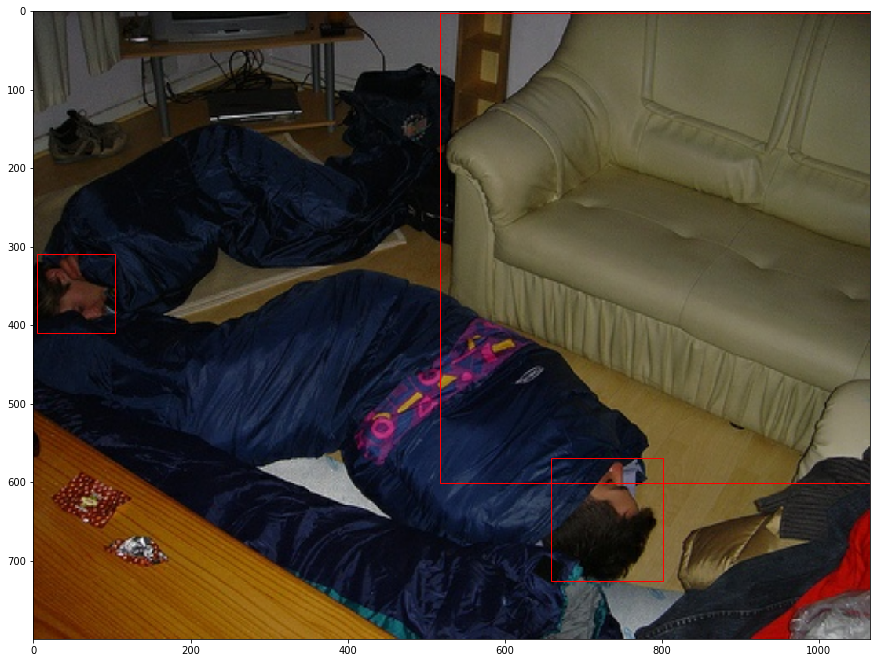

In [23]:
drawing.draw_bounding_boxes(example['images'][0], example['bbox'][0], resize=False,)

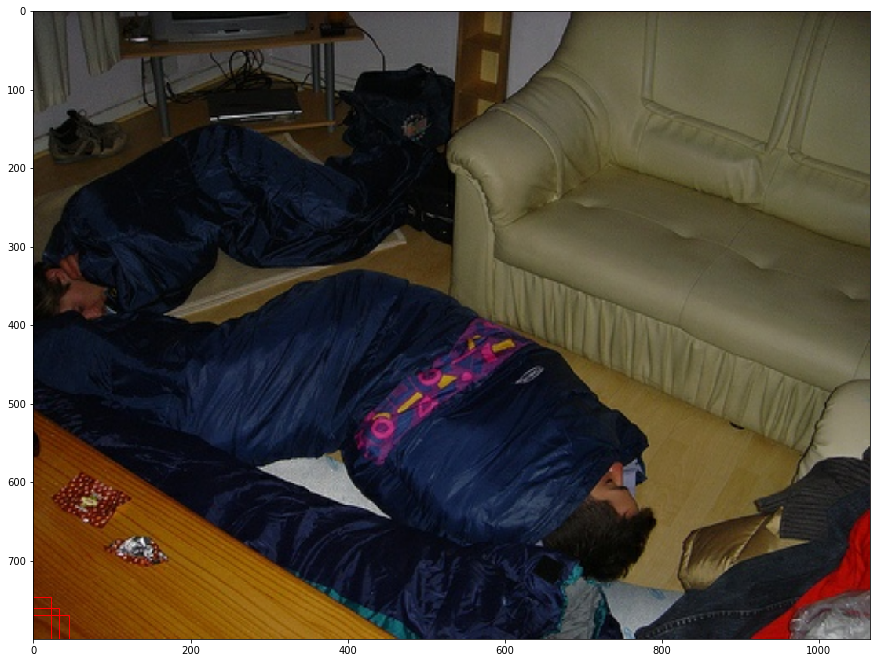

In [24]:
drawing.draw_bounding_boxes(example['images'][0], anchors[199998: 200001], resize=False,)

#  Display matching anchors

In [25]:
matcher = ArgMaxMatcher(0.7, 0.3, force_match_for_each_row=True, dtype=tf.float32)
target_assigner = TargetAssigner(compute_iou, matcher, encode_boxes_faster_rcnn,
                                              dtype=tf.float32)
gt_boxes = tf.unstack(example[BoxField.BOXES])
num_boxes = tf.unstack(example[BoxField.NUM_BOXES])
ground_truths = [{BoxField.BOXES: b[:nb[0]]} for b, nb in zip(gt_boxes, num_boxes)]
y_true, weights, _ = batch_assign_targets(target_assigner, {BoxField.BOXES: anchors}, ground_truths)

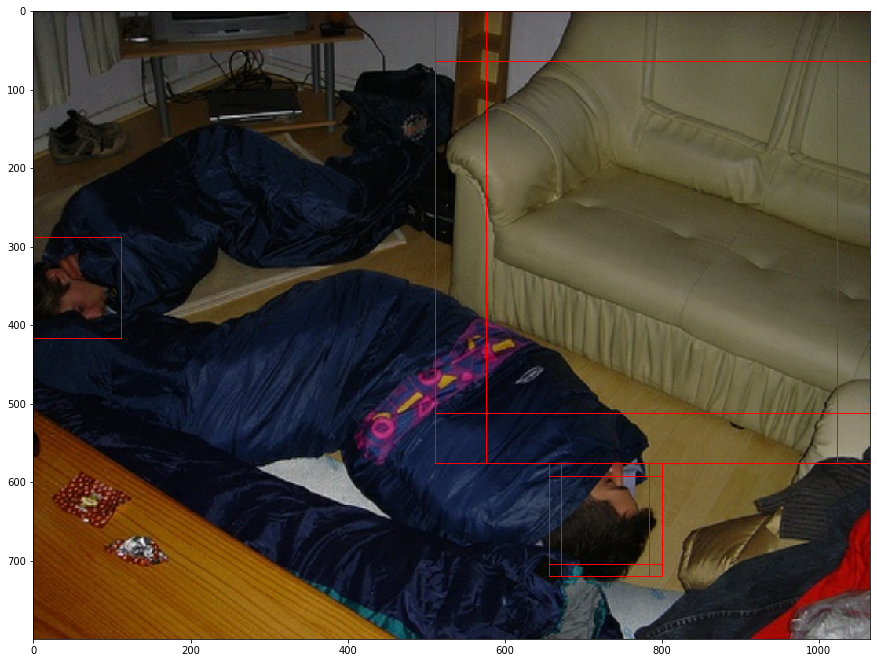

In [26]:
index = tf.where(y_true['classification'] == 1)
matched_boxes = tf.gather(anchors, index[:,1])
drawing.draw_bounding_boxes(example['images'][0], matched_boxes, resize=False,)

In [19]:
ds_info.features['labels']

Sequence(ClassLabel(shape=(), dtype=tf.int64, num_classes=20))

In [12]:
ds_info.features['labels'].names

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)

def train_step(model, inputs):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        gradients = tape.gradient(tf.reduce_sum(model.losses), model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
